In [1]:
import torch
import torch.nn as nn
from collections import OrderedDict

import numpy as np
import matplotlib.pyplot as plt
import scipy.io
import os
from scipy.interpolate import griddata
from mpl_toolkits.axes_grid1 import make_axes_locatable
from contextlib import contextmanager
from pathlib import Path
import subprocess
from functools import partial


# CUDA support
if torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

np.random.seed(1234)

print("Device:", device)

Device: cuda


# We will study Schrödinger's non linear equation in 1D


### $$ih_t +\frac{1}{2}h_{xx} + \mid h\mid^2h = 0, \quad x \in [-5, 5], \quad t \in [0, \frac{\pi}{2}]$$

with the following boundary conditions:
$$h(0, x) = 2 sech(x)$$
$$h(t, -5) = h(t, 5)$$
$$h_x(t, -5) = h_x(t, 5)$$

This is different because we have Complex numbers and not real numbers. $\mid h\mid^2h$ is the module of h squared.
This will show how to solve complex-valued PDEs and periodic boundary conditions.

Let $u = Re(h)$ and $v = Im(h)$, then we can have a neural network prior with 2 outputs, one for $u$ and one for $v$. 



The network will learn to minimize a global mean squared loss composed of the following terms:
- The Initial condition loss (at $t=0$)
- The Boundary condition loss (at $x=-5,5$)
- The PDE loss (at all points in the domain and time)

The final loss will then be:
$$L = L_{IC} + L_{BC} + L_{f}$$

Where:
$$L_{IC} = \frac{1}{N_{IC}}\sum_{i=1}^{N_{IC}} |h(t=0, x_i) - 2sech(x_i)|^2$$
$$L_{BC} = \frac{1}{N_{BC}}\sum_{i=1}^{N_{BC}} |h(t, x_i) - h(t, x_{i+1})|^2 + |h_x(t, x_i) - h_x(t, x_{i+1})|^2$$
$$L_{f} = \frac{1}{N_{f}}\sum_{i=1}^{N_{f}} |ih_t +\frac{1}{2}h_{xx} + \mid h\mid^2h|^2$$

Where $N_{IC}$ is the number of initial condition points, $N_{BC}$ is the number of boundary condition points and $N_{f}$ is the number of points in the domain and time.


In [50]:
data = scipy.io.loadmat("NLS.mat")

t = torch.Tensor(data["tt"].flatten()[:, None])
x = torch.Tensor(data["x"].flatten()[:, None])
Exact = data["uu"]
Exact_u = np.real(Exact)
Exact_v = np.imag(Exact)
Exact_h = np.sqrt(Exact_u**2 + Exact_v**2)

print(f"t = {t.shape}")
print(f"x = {x.shape}")
print(f"u = {Exact_u.shape}")
print(f"v = {Exact_v.shape}")
print(f"h = {Exact_h.shape}")

t = torch.Size([201, 1])
x = torch.Size([256, 1])
u = (256, 201)
v = (256, 201)
h = (256, 201)


In [51]:
# GLOBAL VARIABLES
# Domain bounds
x_min, x_max = x.min(), x.max()  # -5.0, 5.0
t_min, t_max = t.min(), t.max()  # 0.0, pi / 2.0

lb = torch.tensor([x_min, t_min])
ub = torch.tensor([x_max, t_max])

# Number of training points
N_ic = 100
N_bc = 50
N_f = 1000

# We will do the ic and bc together as the training data and f separately
# ic = Initial condition
x_ic = torch.Tensor(N_ic, 1).uniform_(x_min, x_max)
t_ic = torch.zeros(N_ic, 1)
xt_ic = torch.cat((x_ic, t_ic), 1)
# u_ic = 2 * sech(x)
u_ic = 2 * 2 / (torch.exp(x_ic) + torch.exp(-x_ic)) ** 2
v_ic = torch.zeros(N_ic, 1)
uv_ic = torch.cat((u_ic, v_ic), 1)

# bc = Boundary condition
t_bc = torch.Tensor(N_bc, 1).uniform_(t_min, t_max)
x_lb = torch.zeros(N_bc, 1) + x_min
x_ub = torch.zeros(N_bc, 1) + x_max
xt_lb = torch.cat((x_lb, t_bc), 1)
xt_ub = torch.cat((x_ub, t_bc), 1)

# f = PDE
xt_f = lb + (ub - lb) * torch.rand((N_f, 2))
xt_f = torch.cat((xt_ic, xt_lb, xt_ub, xt_f), 0)

# We need xt_ic, uv_ic, xt_lb, xt_ub, xt_f

# Combine the initial, boundary
x_u_train = torch.cat((xt_ic, xt_lb, xt_ub), 0)
t_u_train = torch.cat((t_ic, t_bc, t_bc), 0)

In [52]:
# Print the shapes
print(f"xt_ic = {xt_ic.shape}")
print(f"uv_ic = {uv_ic.shape}")
print(f"xt_lb = {xt_lb.shape}")
print(f"xt_ub = {xt_ub.shape}")
print(f"xt_f = {xt_f.shape}")

xt_ic = torch.Size([100, 2])
uv_ic = torch.Size([100, 2])
xt_lb = torch.Size([50, 2])
xt_ub = torch.Size([50, 2])
xt_f = torch.Size([1200, 2])


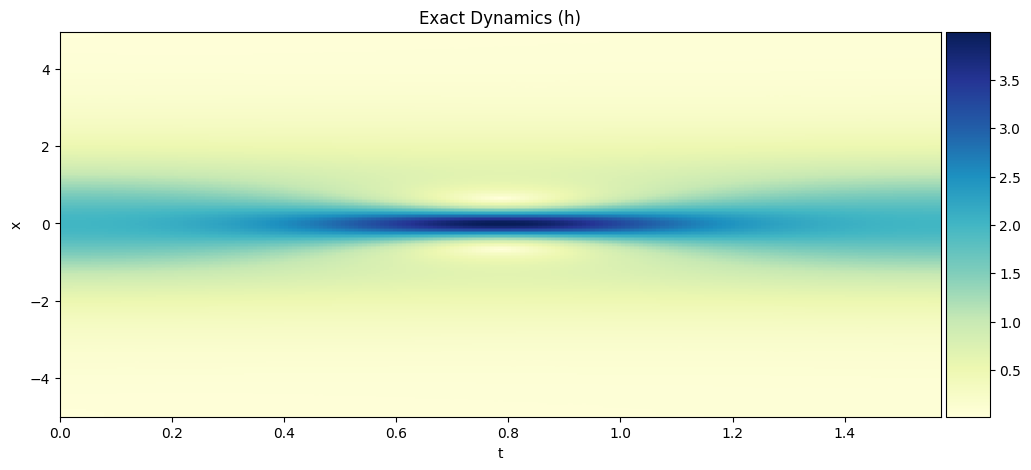

In [53]:
fig = plt.figure(figsize=(12, 5))
ax = fig.add_subplot(111)
h = ax.imshow(
    Exact_h,
    interpolation="nearest",
    cmap="YlGnBu",
    extent=[t.min(), t.max(), x.min(), x.max()],
    origin="lower",
    aspect="auto",
)
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)
fig.colorbar(h, cax=cax, orientation="vertical")
ax.set_xlabel("t")
ax.set_ylabel("x")
ax.set_title("Exact Dynamics (h)")
plt.show()

In [46]:
# Labeled points

N_u = 100  # Number of points to compute the prediction loss (MSE_u)

# À compléter...

x_train = torch.zeros(N_u, 1)
t_train = torch.zeros(N_u, 1)
u_train = torch.zeros(N_u, 1)

print(u_train.shape)

available_t_xmin = torch.arange(t.size(0) - 1)
available_t_xmax = torch.arange(t.size(0) - 1)
available_x_t0 = torch.arange(x.size(0) - 1)
choices = torch.linspace(start=0, end=2, steps=3, dtype=torch.int)

for i in range(N_u):
    choice = np.random.permutation(choices)[0]
    if choice == 0:
        # case (xmin,t)
        x_train[i] = x[0]
        choice_t_xmin = np.random.choice(available_t_xmin)
        np.delete(available_t_xmin, choice_t_xmin)
        t_train[i] = t[choice_t_xmin]
        u_train[i] = u[choice_t_xmin, 0]
    elif choice == 1:
        x_train[i] = x[-1]
        choice_t_xmax = np.random.choice(available_t_xmax)
        np.delete(available_t_xmax, choice_t_xmax)
        t_train[i] = t[choice_t_xmax]
        u_train[i] = u[choice_t_xmax, -1]
    else:
        # case (x,0)
        t_train[i] = t[0]
        choice_x_t0 = np.random.choice(available_x_t0)
        np.delete(available_x_t0, choice_x_t0)
        x_train[i] = x[choice_x_t0]
        u_train[i] = u[0, choice_x_t0]


# Some checks...

assert x_train.shape == (N_u, 1), f"{x_train.shape} != {(N_u, 1)}"
assert t_train.shape == (N_u, 1), f"{t_train.shape} != {(N_u, 1)}"
assert u_train.shape == (N_u, 1), f"{u_train.shape} != {(N_u, 1)}"
assert (
    (t_train == 0) | (x_train == float(x.min())) | (x_train == float(x.max()))
).all(), "Some points do not belong to boundary"

torch.Size([100, 1])


IndexError: index 207 is out of bounds for axis 1 with size 201

In [47]:
# Unlabeled points

N_f = 10000  # Number of points to apply the constraint

# À compléter...
t_idx = torch.arange(t.size(0) - 1)
x_idx = torch.arange(x.size(0) - 1)
x_train_f = x[np.random.choice(x_idx, N_f)].unsqueeze(-1)
t_train_f = t[np.random.choice(t_idx, N_f)].unsqueeze(-1)


# Some checks...

assert x_train_f.shape == (N_f, 1), f"{x_train_f.shape} != {(N_f, 1)}"
assert t_train_f.shape == (N_f, 1), f"{t_train_f.shape} != {(N_f, 1)}"
assert ((x_train_f >= x.min()) & (x_train_f <= x.max())).all()
assert ((t_train_f >= t.min()) & (t_train_f <= t.max())).all()

# Adds boundary points to the unsupervised data set
x_train_f = torch.vstack((x_train_f, x_train))
t_train_f = torch.vstack((t_train_f, t_train))

AssertionError: torch.Size([10000, 1, 1]) != (10000, 1)

In [48]:
# Let's move everything to the target device


def prepare(*tensors):
    return (torch.Tensor(t).float().to(device) for t in tensors)


# Supervised data
x_train, t_train, u_train = prepare(x_train, t_train, u_train)

# Unsupervised data
x_train_f, t_train_f = prepare(x_train_f, t_train_f)

# All data points (for plots)
x_star, t_star = prepare(*X_star.split((1, 1), dim=1))

NameError: name 'X_star' is not defined

ValueError: x and y can be no greater than 2D, but have shapes torch.Size([10000, 1, 1]) and torch.Size([10000, 1, 1])

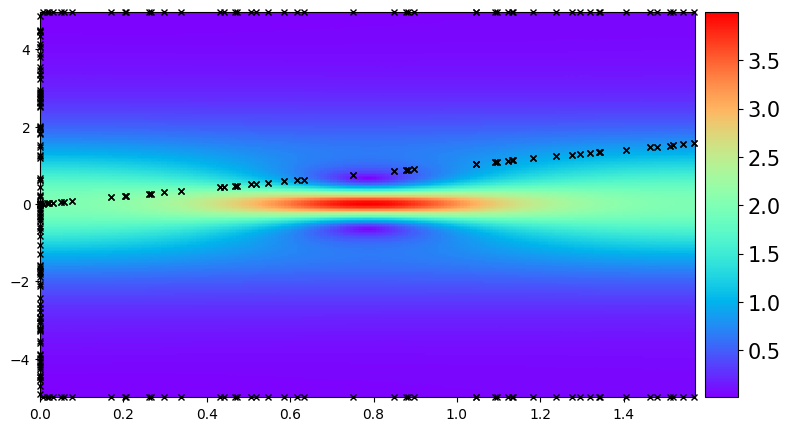

In [49]:
fig = plt.figure(figsize=(9, 5))
ax = fig.add_subplot(111)

h = ax.imshow(
    Exact_h,
    interpolation="nearest",
    cmap="rainbow",
    extent=[t.min(), t.max(), x.min(), x.max()],
    origin="lower",
    aspect="auto",
)

# h = ax.imshow(Exact.T, cmap='rainbow', origin='lower', aspect='auto') # Exact.T size (256,100), u(x,t) avec x[0] = -1
# plt.imshow(Exact.T[::-1,:], cmap='rainbow') # Pour avoir x = -1 en bas

divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.10)
cbar = fig.colorbar(h, cax=cax)
cbar.ax.tick_params(labelsize=15)

ax.plot(
    t_u_train.cpu(),
    x_u_train.cpu(),
    "kx",
    label="Data (%d points)" % (x_u_train.shape[0]),
    markersize=4,  # marker size doubled
    clip_on=False,
    alpha=1.0,
)

ax.plot(
    t_train_f.cpu(),
    x_train_f.cpu(),
    "wx",
    markersize=1,  # marker size doubled
    clip_on=False,
    alpha=0.2,
)

plt.show()

In [24]:
class DNN(torch.nn.Module):
    # À compléter...
    def __init__(self, depth=8, input_size=2, hidden_size=20, output_size=1):
        """
        input of size N_u x 2  = N_u x (x,t) dimensions
        """
        super().__init__()
        self.depth = depth
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size
        layers = [("input", nn.Linear(input_size, hidden_size))]

        layers.append(("activation input", nn.Tanh()))
        for i in range(depth):
            layers.append(
                ("hidden %d" % i, nn.Linear(hidden_size, hidden_size)))
            layers.append(("activation %d" % i, nn.Tanh()))
        layers.append(("output", nn.Linear(hidden_size, output_size)))

        dictLayers = OrderedDict(layers)
        self.seq = nn.Sequential(dictLayers)

    def forward(self, x, t):
        X_u_train = torch.cat((x, t), dim=-1)
        return self.seq(X_u_train)

    @contextmanager
    def eval_mode(self):
        training = self.training
        if training:
            self.eval()
        yield
        if training:
            self.train()

    def predict(self, x: torch.Tensor, t: torch.Tensor):
        with self.eval_mode():
            u = self(x, t)
            u = u.detach().cpu().numpy()
            return u


dnn = DNN()


dnn.to(device)
assert dnn(x_train[:5], t_train[:5]).shape == (
    5,
    1,
), f"{dnn(x_train[5:], t_train[5:]).shape}"

In [25]:
dnn

DNN(
  (seq): Sequential(
    (input): Linear(in_features=2, out_features=20, bias=True)
    (activation input): Tanh()
    (hidden 0): Linear(in_features=20, out_features=20, bias=True)
    (activation 0): Tanh()
    (hidden 1): Linear(in_features=20, out_features=20, bias=True)
    (activation 1): Tanh()
    (hidden 2): Linear(in_features=20, out_features=20, bias=True)
    (activation 2): Tanh()
    (hidden 3): Linear(in_features=20, out_features=20, bias=True)
    (activation 3): Tanh()
    (hidden 4): Linear(in_features=20, out_features=20, bias=True)
    (activation 4): Tanh()
    (hidden 5): Linear(in_features=20, out_features=20, bias=True)
    (activation 5): Tanh()
    (hidden 6): Linear(in_features=20, out_features=20, bias=True)
    (activation 6): Tanh()
    (hidden 7): Linear(in_features=20, out_features=20, bias=True)
    (activation 7): Tanh()
    (output): Linear(in_features=20, out_features=1, bias=True)
  )
)

In [27]:
class pinn_schrodinger(nn.Module):
    def __init__(self, dnn: DNN):
        super().__init__()
        self.dnn = dnn

    def forward(self, x, t):
        x.requires_grad_(True)
        t.requires_grad_(True)

        u = self.dnn(x, t)
        u_x = torch.autograd.grad(u, x, torch.ones_like(u), create_graph=True)[0]
        u_xx = torch.autograd.grad(u_x, x, torch.ones_like(u_x), create_graph=True)[0]
        u_t = torch.autograd.grad(u, t, torch.ones_like(u), create_graph=True)[0]
        return u_t + 0.5 * u_xx + 0.5 * u**3

    def predict(self, x: torch.Tensor, t: torch.Tensor):
        with self.eval_mode():
            u = self(x, t)
            u = u.detach().cpu().numpy()
            return u

    @contextmanager
    def eval_mode(self):
        training = self.training
        if training:
            self.eval()
        yield
        if training:
            self.train()


pinn = pinn_schrodinger(dnn)

pinn.to(device)
assert pinn(x_train[:5], t_train[:5]).shape == (
    5,
    1,
), f"{pinn(x_train[5:], t_train[5:]).shape}"